In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import os
import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

1. Siapin Alat & Bahan
Pertama, kita kumpulin dulu semua "alat masak" dan "bahan-bahan" yang diperlukan. Ini kayak ngeluarin panci, mangkok, bumbu, sama mie dari bungkusnya.

PyTorch (dan teman-temannya): Ini "dapur" utama kita buat bikin AI. Dia yang ngurusin gimana AI-nya belajar.
TorchVision: Ini "kulkas" yang isinya model AI yang udah pintar duluan (namanya ResNet18). Kita tinggal pakai aja kepintarannya. Dia juga punya "jasa salon" buat gambar biar rapi.
Pengelola File: Buat nyari-nyari gambar di folder, buka gambarnya, sama ngatur biar gambar masuk ke AI dengan teratur.
Penganalisis & Pembuat Grafik: Buat ngukur seberapa jago AI kita nebak, dan nampilin hasilnya pakai grafik atau tabel biar gampang dibaca.

In [14]:
class GenderClassificationDataset(Dataset):
    def __init__(self, root_dir, random_seed=42, image_size=224, augment=False):
        self.root_dir = root_dir
        self.image_size = image_size
        self.augment = augment

        if not os.path.exists(self.root_dir):
            raise RuntimeError(f"Dataset not found at {self.root_dir}. Please check the path.")

        self.base_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        if self.augment:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(self.image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = self.base_transform

        self.data = []    
        self.labels = []  

        for label, class_name in tqdm(enumerate(['male', 'female']), desc="Loading Dataset"):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Class directory '{class_name}' not found at {class_dir}. Skipping.")
                continue
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg')) 
            if not image_paths:
                print(f"Warning: No .jpg images found in '{class_dir}'. Skipping.")
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

2. Ajari AI Cara Makan Gambar (Kelas Dataset)
Nah, AI kita kan makannya gambar. Kita ajarin dia cara ngambil gambar dari folder, terus nyiapinnya biar pas buat dimakan.

Kita bikin "asisten" khusus yang tugasnya ngambil gambar dari folder male dan female di folder Training dan Validation.
Setiap gambar yang diambil, dia bakal "disalonin" dulu: diubah ukurannya biar seragam, terus dinormalisasi (kayak dicuci bersih).
Buat gambar latihan, gambarnya bakal "diacak-acak" dikit (misal: dibalik, diputar, diubah warna dikit). Ini biar AI-nya enggak cuma hafal gambar itu-itu aja, tapi bisa nebak gambar yang mirip-mirip juga. Biar enggak gampang ketipu!

In [15]:
batch_size = 32
test_batch_size = 32 

train_dataset = GenderClassificationDataset(
    root_dir='/kaggle/input/gender-classification-dataset/Training', 
    augment=True 
)
test_dataset  = GenderClassificationDataset(
    root_dir='/kaggle/input/gender-classification-dataset/Validation', 
    augment=False 
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = resnet18(weights=ResNet18_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) 
model = model.to(device) 

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4) 

for param in model.parameters():
    param.requires_grad = False 
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters (only fc layer for now): {trainable_params / 1e6:.2f}M")

Loading Dataset: 2it [00:00,  6.85it/s]
Loading Dataset: 2it [00:00, 108.22it/s]


Using device: cuda
Total parameters: 11.18M
Trainable parameters (only fc layer for now): 0.00M


3. Pasang Otak AI & Siapin Pelatihan
Sekarang, kita pasang "otak" AI-nya dan atur gimana dia bakal belajar dari gambar-gambar tadi.

Pasang Otak ResNet18: Kita pakai otak ResNet18 yang udah pintar tadi. Tapi, karena ResNet18 aslinya pintar nebak 1000 hal (ImageNet), kita cuma ganti "bagian penentu" terakhirnya jadi 2 pilihan aja (cowok atau cewek).
Mode Belajar Cerdas: Kita kasih tahu AI-nya kalau dia harus belajar dengan cerdas. Kita bekukan sebagian besar otaknya yang udah pintar (biar enggak rusak pengetahuannya), dan cuma bagian "penentu cowok/cewek" aja yang boleh diubah-ubah pas belajar.
Siapin Gurunya: Kita atur "guru" (optimizer Adam) dan "buku catatan kesalahan" (loss function CrossEntropyLoss) biar AI bisa tahu seberapa salah tebakannya dan gimana caranya biar besok nebaknya makin bener.


Starting training process...


Epoch 1 (Test): 100%|██████████| 365/365 [00:58<00:00,  6.22it/s]


Epoch 1: Train Loss 0.6056, Train Acc 0.6680, Test Loss 0.5558, Test Acc 0.7058


Epoch 2 (Test): 100%|██████████| 365/365 [00:58<00:00,  6.20it/s]


Epoch 2: Train Loss 0.5361, Train Acc 0.7296, Test Loss 0.5155, Test Acc 0.7420


Epoch 3 (Test): 100%|██████████| 365/365 [00:58<00:00,  6.23it/s]


Epoch 3: Train Loss 0.5137, Train Acc 0.7459, Test Loss 0.4931, Test Acc 0.7630


Epoch 4 (Test): 100%|██████████| 365/365 [00:58<00:00,  6.26it/s]


Epoch 4: Train Loss 0.5043, Train Acc 0.7524, Test Loss 0.4751, Test Acc 0.7743


Epoch 5 (Test): 100%|██████████| 365/365 [00:59<00:00,  6.16it/s]


Epoch 5: Train Loss 0.4990, Train Acc 0.7579, Test Loss 0.4813, Test Acc 0.7708


Epoch 6 (Test): 100%|██████████| 365/365 [01:00<00:00,  6.06it/s]


Epoch 6: Train Loss 0.4934, Train Acc 0.7591, Test Loss 0.4709, Test Acc 0.7755


Epoch 7 (Test): 100%|██████████| 365/365 [01:00<00:00,  6.07it/s]


Epoch 7: Train Loss 0.4912, Train Acc 0.7598, Test Loss 0.4603, Test Acc 0.7839


Epoch 8 (Test): 100%|██████████| 365/365 [00:59<00:00,  6.17it/s]


Epoch 8: Train Loss 0.4887, Train Acc 0.7603, Test Loss 0.4493, Test Acc 0.7929


Epoch 9 (Test): 100%|██████████| 365/365 [00:59<00:00,  6.16it/s]


Epoch 9: Train Loss 0.4853, Train Acc 0.7633, Test Loss 0.4450, Test Acc 0.7947


Epoch 10 (Test): 100%|██████████| 365/365 [00:59<00:00,  6.13it/s]


Epoch 10: Train Loss 0.4819, Train Acc 0.7663, Test Loss 0.4417, Test Acc 0.8009

--- Final Evaluation on Test Set ---


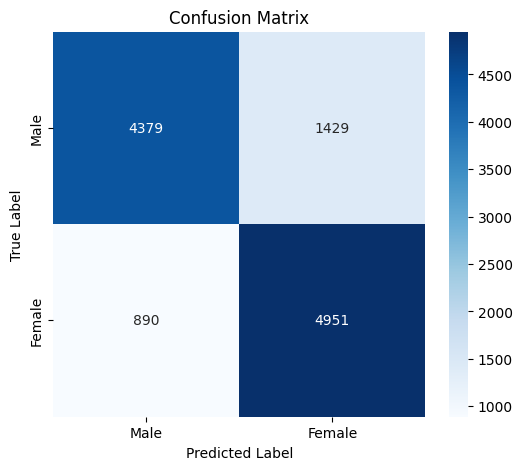


Classification Report:
              precision    recall  f1-score   support

        Male       0.83      0.75      0.79      5808
      Female       0.78      0.85      0.81      5841

    accuracy                           0.80     11649
   macro avg       0.80      0.80      0.80     11649
weighted avg       0.80      0.80      0.80     11649



In [16]:
num_epoch = 10 
train_losses = []      
test_losses = []       
train_accuracies = []  
test_accuracies = []   

print("\nStarting training process...")
for epoch in range(num_epoch):
    model.train() 
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
        data, labels = data.to(device), labels.to(device) 
        optimizer.zero_grad() 
        
        outputs = model(data) 
        loss = criterion(outputs, labels) 
        
        loss.backward() 
        optimizer.step() 

        train_loss += loss.item() * data.size(0) 
        _, preds = torch.max(outputs, 1) 
        correct_train += (preds == labels).sum().item() 
        total_train += labels.size(0) 

    model.eval() 
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    all_preds = []    
    all_labels = []   

    with torch.no_grad(): 
        for data, labels in tqdm(test_loader, desc=f"Epoch {epoch+1} (Test)"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(outputs, 1) 
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy()) 

    avg_train_loss = train_loss / total_train
    train_acc = correct_train / total_train
    avg_test_loss = test_loss / total_test
    test_acc = correct_test / total_test

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Train Acc {train_acc:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {test_acc:.4f}")

print("\n--- Final Evaluation on Test Set ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Male', 'Female']))

4. Sesi Belajar & Ujian AI (Loop Pelatihan)
Ini dia bagian paling seru! AI kita bakal belajar dan dites berulang kali.

Berulang Kali (Epoch): AI kita bakal belajar dari semua gambar, terus dites, diulang lagi, diulang lagi, sebanyak num_epoch kali (misal 10 kali).
Belajar (Mode train()): Di setiap putaran, AI akan melihat gambar-gambar latihan per kelompok kecil (batch), nebak, terus ngitung salahnya. Dari salah itu, dia bakal ngubah otaknya dikit demi sedikit biar besok nebaknya makin bener.
Ujian (Mode eval()): Setelah belajar satu putaran, AI bakal dites pakai gambar validasi (gambar yang belum pernah dia lihat pas belajar). Di sini dia cuma boleh nebak, enggak boleh ngubah otaknya. Ini buat mastiin dia beneran pintar, bukan cuma hafal.
Rapor Per Putaran: Setiap selesai belajar dan ujian satu putaran, kita lihat nilainya (loss dan akurasi). Biar tahu progresnya naik atau turun.
Rapor Akhir (Confusion Matrix): Setelah semua putaran selesai, kita lihat rapor paling pentingnya. Ada tabel yang nunjukkin berapa bener dia nebak cowok, berapa bener dia nebak cewek, dan berapa kali dia salah (cowok dibilang cewek atau sebaliknya). Kerennya, ini pakai heatmap jadi warnanya bagus.


Model checkpoint saved as 'gender_classification_checkpoint.pth'


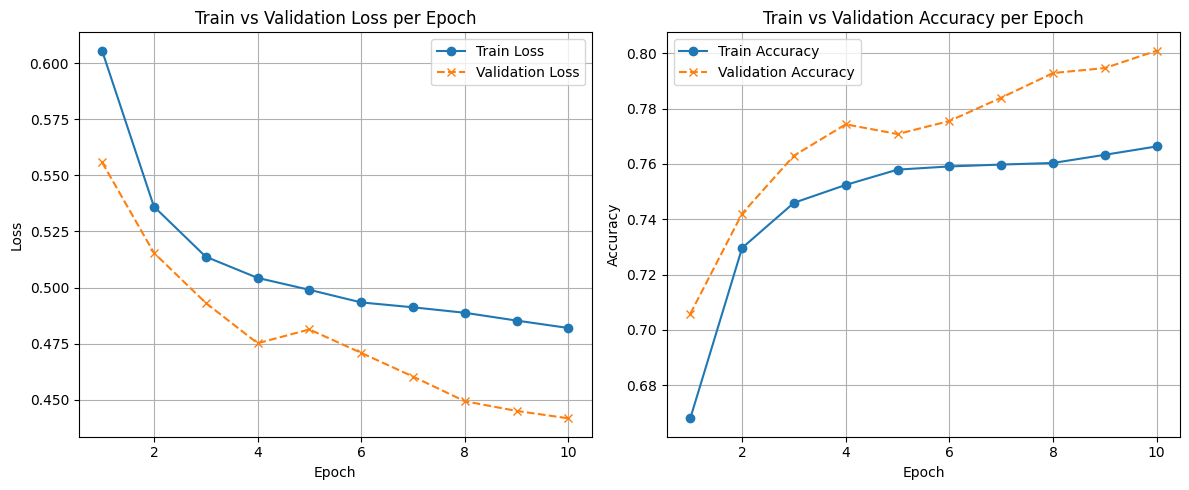

In [17]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
    'train_accuracies': train_accuracies, 
    'test_accuracies': test_accuracies,   
}, 'gender_classification_checkpoint.pth') 

print(f"Model checkpoint saved as 'gender_classification_checkpoint.pth'")

epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) 
plt.plot(epochs, train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, test_losses, label='Validation Loss', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) 
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, test_accuracies, label='Validation Accuracy', marker='x', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()

5. Abadikan Ilmu & Lihat Grafik Perjalanan
Setelah selesai belajar, kita "simpan" otaknya AI biar ilmunya enggak hilang. Terus kita lihat grafik perjalanan belajarnya.

Simpan Otak AI: Kita save otaknya AI (.pth file) kayak nyimpan save game. Jadi, kalau besok mau pakai lagi atau mau lanjutin belajar, tinggal load aja.
Grafik Perjalanan: Kita bikin grafik yang nunjukkin gimana nilai loss (kesalahan) dan akurasi AI kita berubah selama belajar. Kita bisa lihat apakah dia makin pintar atau malah overfitting (jago di latihan tapi pas ujian jeblok).

In [18]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)
    
    model = resnet18(weights=None) 
    model.fc = nn.Linear(model.fc.in_features, num_classes) 
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device) 
    model.eval() 
    return model

def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.229, 0.225]) # Fixed typo here: std[3] was 0.225, should be 0.225
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad(): 
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1) 

    predicted_class = class_names[pred.item()]
    return predicted_class, image

6. Bikin Fungsi Peramal Gambar
Nah, ini fungsi yang bikin AI kita bisa jadi "peramal" gambar. Tinggal kasih gambar, dia langsung nebak!

Kita punya fungsi load_model buat manggil lagi otak AI yang udah disimpen tadi.
Terus ada fungsi predict_image yang tugasnya ngambil satu gambar, nyalonin gambarnya kayak biasa, terus disuruh nebak. Hasilnya dikasih tahu deh!

Prediction for fritzy.jpg: female


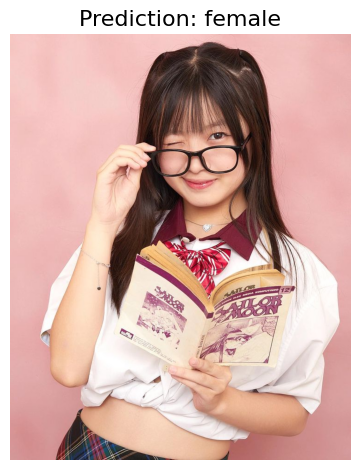

In [24]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['male', 'female']

    model_path = 'gender_classification_checkpoint.pth' 
    if not os.path.exists(model_path):
        print(f"Error: Model checkpoint not found at '{model_path}'. Please ensure training completed and checkpoint saved.")
    else:
        model = load_model(model_path, num_classes=len(class_names), device=device)

        img_path = '/kaggle/input/hasilpercobaan/prediksi/fritzy.jpg' 
        
        if not os.path.exists(img_path):
            print(f"Error: Image not found at '{img_path}'. Please provide a valid path to a male image.")
        else:
            predicted_label, image = predict_image(img_path, model, device, class_names)

            print(f"Prediction for {os.path.basename(img_path)}: {predicted_label}")
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Prediction: {predicted_label}", fontsize=16)
            plt.tight_layout()
            plt.show()

Kita siapkan dulu "otak" AI kita dengan memuat model yang sudah dilatih dari file gender_classification_checkpoint.pth. Ini biar kita enggak usah ngelatih dari awal lagi.
Terus, kita tentukan lokasi gambar yang mau ditebak. Di sini, kita pakai gambar di /kaggle/input/hasilpercobaan/prediksi/fritzy.jpg. Pastikan gambar ini beneran ada di lokasi itu ya!
Modelnya disuruh nebak gender dari gambar fritzy.jpg ini.
Hasil tebakannya (misal: "male" atau "female") akan dicetak di layar, dan gambarnya sendiri akan ditampilkan dengan judul yang menunjukkan hasil tebakan AI. Jadi, kita bisa langsung lihat AI kita nebaknya bener atau enggak.

Prediction for laki laki.jpg: male


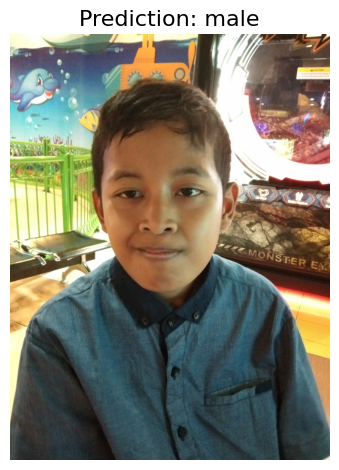

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_names = ['male', 'female']

model_path = 'gender_classification_checkpoint.pth' 
if not os.path.exists(model_path):
    print(f"Error: Model checkpoint not found at '{model_path}'. Please ensure training completed and checkpoint saved.")
else:
    model = load_model(model_path, num_classes=len(class_names), device=device)

    img_path = '/kaggle/input/hasilpercobaan/prediksi/laki laki.jpg' 
    
    if not os.path.exists(img_path):
        print(f"Error: Image not found at '{img_path}'. Please provide a valid path to a male image.")
    else:
        predicted_label, image = predict_image(img_path, model, device, class_names)

        print(f"Prediction for {os.path.basename(img_path)}: {predicted_label}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_label}", fontsize=16)
        plt.tight_layout()
        plt.show()